CASA 0002 - Urban Simulation
Final Asssessment - London Underground Resilience
Gavin Rolls
9 February 2024

Environment Setup

In [102]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Part II - Spatial Interaction Models

Data Loading & Preprocessing

In [103]:
#Reading in flows
flows = pd.read_csv("./Data/london_flows.csv")

#Check data loaded
flows.head()

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167


In [104]:
#Metric Calculations(Taken from Prac3)
def CalcRSqaured(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(np.sqrt(res.mean()), 3)
    
    return RMSE

Set up Origin Constrained Model with Exponential Decay.

I will use population as our origin mass factor and employment count as our destination mass factor to simulate maximum commute flow during the morning rush.

In [105]:
#Calculate log of destination employment count with small addition to solve div by zero error
flows['log_dest_jobs'] = np.log(flows['jobs'] + .001)

#Formula for origin constrained equation (with exponential decay)
eq_form = 'flows ~ station_origin + log_dest_jobs + distance-1'

#Doubly Constrained Model with smf
sim = smf.glm(formula = eq_form, data = flows, family=sm.families.Poisson()).fit()

print(sim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61474
Model:                            GLM   Df Residuals:                    61073
Model Family:                 Poisson   Df Model:                          400
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.2195e+05
Date:                Sun, 25 Feb 2024   Deviance:                   1.6717e+06
Time:                        15:02:03   Pearson chi2:                 2.42e+06
No. Iterations:                    26   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [106]:
#Generate Predictions and add to flows dataframe
flows["flows_default"] = np.round(sim.mu)

#Summary Statistics
print("RSquared =")
print(CalcRSqaured(flows["flows"], flows["flows_default"]))
print("RMSE =")
print(CalcRMSE(flows["flows"], flows["flows_default"]))

RSquared =
0.4482759616475261
RMSE =
97.845


Our log_jobs parameter is 0.7509 and our distance parameter is -0.00015 (Remember beta is the inverse of this)

In [107]:
#Matrix View (Code Taken from Practical 3)
matrix = flows.pivot_table(values ="flows_default", index="station_origin", columns = "station_destination",
                                    aggfunc=np.sum, margins=True)
matrix

/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_1342/700295113.py:2: FutureWarning: The provided callable <function sum at 0x105eb5940> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  matrix = flows.pivot_table(values ="flows_default", index="station_origin", columns = "station_destination",
/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_1342/700295113.py:2: FutureWarning: The provided callable <function sum at 0x105eb5940> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  matrix = flows.pivot_table(values ="flows_default", index="station_origin", columns = "station_destination",
/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_1342/700295113.py:2: FutureWarning: The provided callable <function sum at 0x10

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,598.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,13.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3745.0
Aldgate,NaN,NaN,1.0,NaN,37.0,NaN,NaN,0.0,NaN,27.0,...,2.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2884.0
Aldgate East,NaN,NaN,1.0,40.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,1.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3165.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,41.0,52.0,NaN,NaN,NaN,NaN,30.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4861.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,534.0
Woodside Park,NaN,NaN,2.0,19.0,19.0,NaN,0.0,NaN,NaN,31.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3099.0


## Scenario A - Decrease in Jobs at Canary Wharf

In [108]:
#Create new jobs column for scenario a and cut Canary Wharf's jobs in half
flows["jobs_scenario_a"] = flows["jobs"]

#Find Canary Wharf Rows
cw_indices = flows.index[flows['station_destination'] == 'Canary Wharf']

#Divide by Two
flows.loc[cw_indices, 'jobs_scenario_a'] /= 2

#Check it's worked
flows.head()

,station_origin,station_destination,flows,population,jobs,distance,log_dest_jobs,flows_default,jobs_scenario_a
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271478,78.0,78549
1,Abbey Road,Beckton,1,599,442,8510.121774,6.091312,2.0,442
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.499789,4.0,665
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981421,99.0,29386
4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.643939,56.0,15428


In [109]:
#Set parameters 
params = sim.params
alpha_i = params[:2]
gamma = params[-2]
beta = -params[-1]

coefs = pd.DataFrame(sim.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)

#Strip coef column content
coefs["coef"] = coefs["coef"].str.lstrip('station_origin[').str.rstrip(']')

flows = flows.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
flows.drop(columns = ["coef"], inplace = True)

/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_1342/3348131867.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gamma = params[-2]
/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_1342/3348131867.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = -params[-1]


In [110]:
#Calculate flows using 'raw' equation

#Recalculate A_i such that flows between other stations are recalibrated correctly
Dj_gamma = flows["jobs_scenario_a"]**gamma
dist_decay = np.exp(flows['distance']*(-beta))

#Recalculate alpha_i for scenario a
flows["alpha_i_partial"] = Dj_gamma * dist_decay

#Sum over all destinations
A_i = pd.DataFrame(flows.groupby(["station_origin"])["alpha_i_partial"].agg(np.sum))

#Divide over 1
A_i["alpha_i_partial"] = 1/A_i["alpha_i_partial"]

#Rename
A_i.rename(columns={"alpha_i_partial":"alpha_i_sec_a"}, inplace=True)

#and write the A_i values back into the dataframe
flows = flows.merge(A_i, left_on="station_origin", right_index=True, how="left")

#Calculate new flows with change @ Canary Wharf
flows["flows_scenario_a"] = np.round(flows["alpha_i_sec_a"]*flows["population"]*Dj_gamma*dist_decay)

flows.head(50)

/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_1342/133780993.py:11: FutureWarning: The provided callable <function sum at 0x105eb5940> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  A_i = pd.DataFrame(flows.groupby(["station_origin"])["alpha_i_partial"].agg(np.sum))


,station_origin,station_destination,flows,population,jobs,distance,log_dest_jobs,flows_default,jobs_scenario_a,alpha_i,alpha_i_partial,alpha_i_sec_a,flows_scenario_a
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271478,78.0,78549,-2.881022,1390.576011,0.000100,84.0
1,Abbey Road,Beckton,1,599,442,8510.121774,6.091312,2.0,442,-2.881022,26.857420,0.000100,2.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.499789,4.0,665,-2.881022,74.540461,0.000100,4.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981421,99.0,29386,-2.881022,1051.967464,0.000100,63.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.643939,56.0,15428,-2.881022,997.802881,0.000100,60.0
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,7.096722,4.0,1208,-2.881022,75.230123,0.000100,5.0
6,Abbey Road,Custom House,0,599,845,3824.855630,6.739338,5.0,845,-2.881022,88.567990,0.000100,5.0
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,7.466228,4.0,1748,-2.881022,75.483796,0.000100,5.0
8,Abbey Road,Cyprus,7,599,850,6532.099618,6.745238,3.0,850,-2.881022,59.139626,0.000100,4.0
9,Abbey Road,Devons Road,1,599,611,3958.324171,6.415099,4.0,611,-2.881022,68.044833,0.000100,4.0


In [111]:
#Matrix View (Code Taken from Practical 3)
matrix = flows.pivot_table(values ="flows_scenario_a", index="station_origin", columns = "station_destination",
                                    aggfunc=np.sum, margins=True)
matrix

/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_1342/407003000.py:2: FutureWarning: The provided callable <function sum at 0x105eb5940> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  matrix = flows.pivot_table(values ="flows_scenario_a", index="station_origin", columns = "station_destination",
/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_1342/407003000.py:2: FutureWarning: The provided callable <function sum at 0x105eb5940> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  matrix = flows.pivot_table(values ="flows_scenario_a", index="station_origin", columns = "station_destination",
/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_1342/407003000.py:2: FutureWarning: The provided callable <function sum a

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,602.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,14.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3746.0
Aldgate,NaN,NaN,1.0,NaN,37.0,NaN,NaN,0.0,NaN,28.0,...,2.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2880.0
Aldgate East,NaN,NaN,1.0,40.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,1.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3164.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,42.0,53.0,NaN,NaN,NaN,NaN,31.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4858.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,534.0
Woodside Park,NaN,NaN,2.0,20.0,19.0,NaN,0.0,NaN,NaN,32.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3098.0


To verify that commuters are indeed preserved, we can take the sum total traveler count from our matrix view here, 
1,541,507, and compare it to the total count from our previous matrix, which is 1,541,509. The difference of two commuters can be comfortably attributed to rounding errors


## Scenario B - Increase in Travel Cost

In [112]:
#Establish new value for beta - reflecting cost of travel (in terms of distance)
print("Default Beta: " + str(beta))

#Given that beta is relatively small, I will consider a scenario in which beta is 50% larger and 100% larger from its default value
beta_b1 = beta*1.5
beta_b2 = beta*2

#Calculate flows using 'raw' equation

#Recalculate A_i such that flows between other stations are recalibrated correctly
Dj_gamma = flows["jobs"]**gamma
dist_decay_b1 = np.exp(flows['distance']*(-beta_b1))
dist_decay_b2 = np.exp(flows['distance']*(-beta_b2))

#Recalculate alpha_i for scenario a
flows["alpha_i_partial_b1"] = Dj_gamma * dist_decay_b1
flows["alpha_i_partial_b2"] = Dj_gamma * dist_decay_b2

#Sum over all destinations
A_i_b1 = pd.DataFrame(flows.groupby(["station_origin"])["alpha_i_partial_b1"].agg(np.sum))
A_i_b2 = pd.DataFrame(flows.groupby(["station_origin"])["alpha_i_partial_b2"].agg(np.sum))

#Divide over 1
A_i_b1["alpha_i_partial_b1"] = 1/A_i_b1["alpha_i_partial_b1"]
A_i_b2["alpha_i_partial_b2"] = 1/A_i_b2["alpha_i_partial_b2"]

#Rename
A_i_b1.rename(columns={"alpha_i_partial_b1":"alpha_i_sec_b1"}, inplace=True)
A_i_b2.rename(columns={"alpha_i_partial_b2":"alpha_i_sec_b2"}, inplace=True)

#and write the A_i values back into the dataframe
flows = flows.merge(A_i_b1, left_on="station_origin", right_index=True, how="left")
flows = flows.merge(A_i_b2, left_on="station_origin", right_index=True, how="left")

#Calculate new flows for scenario b1
flows["flows_scenario_b1"] = np.round(flows["alpha_i_sec_b1"]*flows["population"]*Dj_gamma*dist_decay_b1)

#Calculate new flows for scenario b2
flows["flows_scenario_b2"] = np.round(flows["alpha_i_sec_b2"]*flows["population"]*Dj_gamma*dist_decay_b2)

flows.head(50)

Default Beta: 0.0001508173847438574


/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_1342/1809123172.py:20: FutureWarning: The provided callable <function sum at 0x105eb5940> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  A_i_b1 = pd.DataFrame(flows.groupby(["station_origin"])["alpha_i_partial_b1"].agg(np.sum))
/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_1342/1809123172.py:21: FutureWarning: The provided callable <function sum at 0x105eb5940> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  A_i_b2 = pd.DataFrame(flows.groupby(["station_origin"])["alpha_i_partial_b2"].agg(np.sum))


,station_origin,station_destination,flows,population,jobs,distance,log_dest_jobs,flows_default,jobs_scenario_a,alpha_i,alpha_i_partial,alpha_i_sec_a,flows_scenario_a,alpha_i_partial_b1,alpha_i_partial_b2,alpha_i_sec_b1,alpha_i_sec_b2,flows_scenario_b1,flows_scenario_b2
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271478,78.0,78549,-2.881022,1390.576011,0.000100,84.0,753.166005,407.930978,0.000123,0.000155,55.0,38.0
1,Abbey Road,Beckton,1,599,442,8510.121774,6.091312,2.0,442,-2.881022,26.857420,0.000100,2.0,14.137134,7.441466,0.000123,0.000155,1.0,1.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.499789,4.0,665,-2.881022,74.540461,0.000100,4.0,56.072215,42.179687,0.000123,0.000155,4.0,4.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981421,99.0,29386,-2.881022,1051.967464,0.000100,63.0,1206.332683,822.026645,0.000123,0.000155,89.0,76.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.643939,56.0,15428,-2.881022,997.802881,0.000100,60.0,843.428862,712.938656,0.000123,0.000155,62.0,66.0
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,7.096722,4.0,1208,-2.881022,75.230123,0.000100,5.0,45.437299,27.443105,0.000123,0.000155,3.0,3.0
6,Abbey Road,Custom House,0,599,845,3824.855630,6.739338,5.0,845,-2.881022,88.567990,0.000100,5.0,66.376504,49.745290,0.000123,0.000155,5.0,5.0
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,7.466228,4.0,1748,-2.881022,75.483796,0.000100,5.0,39.751601,20.934159,0.000123,0.000155,3.0,2.0
8,Abbey Road,Cyprus,7,599,850,6532.099618,6.745238,3.0,850,-2.881022,59.139626,0.000100,4.0,36.137247,22.081651,0.000123,0.000155,3.0,2.0
9,Abbey Road,Devons Road,1,599,611,3958.324171,6.415099,4.0,611,-2.881022,68.044833,0.000100,4.0,50.484924,37.456591,0.000123,0.000155,4.0,3.0


In [113]:
#Matrix View (Code Taken from Practical 3)
matrix = flows.pivot_table(values ="flows_scenario_b1", index="station_origin", columns = "station_destination",
                                    aggfunc=np.sum, margins=True)
matrix

/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_1342/1370140591.py:2: FutureWarning: The provided callable <function sum at 0x105eb5940> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  matrix = flows.pivot_table(values ="flows_scenario_b1", index="station_origin", columns = "station_destination",
/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_1342/1370140591.py:2: FutureWarning: The provided callable <function sum at 0x105eb5940> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  matrix = flows.pivot_table(values ="flows_scenario_b1", index="station_origin", columns = "station_destination",
/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_1342/1370140591.py:2: FutureWarning: The provided callable <function 

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,597.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,8.0,8.0,NaN,20.0,0.0,NaN,11.0,...,9.0,2.0,1.0,26.0,NaN,0.0,NaN,0.0,NaN,3744.0
Aldgate,NaN,NaN,1.0,NaN,46.0,NaN,NaN,0.0,NaN,29.0,...,1.0,NaN,1.0,1.0,NaN,0.0,NaN,0.0,NaN,2875.0
Aldgate East,NaN,NaN,1.0,50.0,NaN,NaN,0.0,0.0,NaN,31.0,...,1.0,0.0,1.0,1.0,NaN,0.0,NaN,0.0,NaN,3156.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.0,36.0,51.0,NaN,NaN,NaN,NaN,23.0,...,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,4861.0
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,529.0
Woodside Park,NaN,NaN,1.0,16.0,15.0,NaN,0.0,NaN,NaN,32.0,...,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,3092.0


In [116]:
#All Scenarios Compared Directly against each other
col_names = ['station_origin', 'station_destination', 'flows_default', 'flows_scenario_a', 'flows_scenario_b1', 'flows_scenario_b2']

flows.iloc[:][col_names].head(50)


,station_origin,station_destination,flows_default,flows_scenario_a,flows_scenario_b1,flows_scenario_b2
0,Abbey Road,Bank and Monument,78.0,84.0,55.0,38.0
1,Abbey Road,Beckton,2.0,2.0,1.0,1.0
2,Abbey Road,Blackwall,4.0,4.0,4.0,4.0
3,Abbey Road,Canary Wharf,99.0,63.0,89.0,76.0
4,Abbey Road,Canning Town,56.0,60.0,62.0,66.0
5,Abbey Road,Crossharbour,4.0,5.0,3.0,3.0
6,Abbey Road,Custom House,5.0,5.0,5.0,5.0
7,Abbey Road,Cutty Sark,4.0,5.0,3.0,2.0
8,Abbey Road,Cyprus,3.0,4.0,3.0,2.0
9,Abbey Road,Devons Road,4.0,4.0,4.0,3.0


## Analysis of Changes in Commuter Flow

Ideas

Scatterplot of average commuters by distance between station by scenario - could run regression here?
Percent difference in commute flows per station pair between the models (could also be scatterplot)


In [154]:
#Making new dataframe to mess with for analysis
condensed = flows.iloc[:][col_names]

#Canary Wharf Changes
condensed['change_a'] = condensed['flows_scenario_a'] - condensed['flows_default']

print('Median Change to Scenario A: ' + str(np.median(condensed['change_a'])))
print('Percent of pairs with increased flow: ' + str((condensed['change_a'] > 0).mean() * 100))
print('Percent of pairs with no change in flow: ' + str((condensed['change_a'] == 0).mean() * 100))
print('Percent of pairs with decreased flow: ' + str((condensed['change_a'] < 0).mean() * 100))

canary_wharf_rows = condensed[condensed['station_destination'] == 'Canary Wharf']

canary_orig = canary_wharf_rows['flows_default'].sum()
canary_new = canary_wharf_rows['flows_scenario_a'].sum()

print('Original Flows to Canary Wharf: ' + str(canary_orig))
print('New Flows to Canary Wharf: ' + str(canary_new))
print('Percent decrease of flows to Canary Wharf: ' + str(((canary_new - canary_orig) / canary_orig) * 100))

condensed['pct_change_a'] = abs(((condensed['flows_scenario_a'] - condensed['flows_default']) / condensed['flows_default']) * 100)

pct_change_a = condensed['pct_change_a']
valid_values_a = pct_change_a[np.isfinite(pct_change_a)]
average_a = np.mean(valid_values_a)
print('Average Percent Change in Scenario A: {:.2f}'.format(average_a))

Median Change to Scenario A: 0.0
Percent of pairs with increased flow: 14.43862445912093
Percent of pairs with no change in flow: 85.06523082929368
Percent of pairs with decreased flow: 0.4961447115853857
Original Flows to Canary Wharf: 48514.0
New Flows to Canary Wharf: 30075.0
Percent decrease of flows to Canary Wharf: -38.00758543925465
Average Percent Change in Scenario A: 1.33


In [152]:
#Scenario B Changes

#General stats
condensed['change_b1'] = condensed['flows_scenario_b1'] - condensed['flows_default']
condensed['change_b2'] = condensed['flows_scenario_b2'] - condensed['flows_default']

print('Median Change to Scenario B1: ' + str(np.median(condensed['change_b1'])))
print('Percent of pairs with increased flow: ' + str((condensed['change_b1'] > 0).mean() * 100))
print('Percent of pairs with no change in flow: ' + str((condensed['change_b1'] == 0).mean() * 100))
print('Percent of pairs with decreased flow: ' + str((condensed['change_b1'] < 0).mean() * 100))

print('Median Change to Scenario B2: ' + str(np.median(condensed['change_b2'])))
print('Percent of pairs with increased flow: ' + str((condensed['change_b2'] > 0).mean() * 100))
print('Percent of pairs with no change in flow: ' + str((condensed['change_b2'] == 0).mean() * 100))
print('Percent of pairs with decreased flow: ' + str((condensed['change_b2'] < 0).mean() * 100))


condensed['pct_change_b1'] = abs(((condensed['flows_scenario_b1'] - condensed['flows_default']) / condensed['flows_default']) * 100)
condensed['pct_change_b2'] = abs(((condensed['flows_scenario_b2'] - condensed['flows_default']) / condensed['flows_default']) * 100)

pct_change_b1 = condensed['pct_change_b1']
valid_values_b1 = pct_change_b1[np.isfinite(pct_change_b1)]
average_b1 = np.mean(valid_values_b1)
print('Average Percent Change in Scenario B1: {:.2f}'.format(average_b1))

pct_change_b2 = condensed['pct_change_b2']
valid_values_b2 = pct_change_b2[np.isfinite(pct_change_b2)]
average_b2 = np.mean(valid_values_b2)
print('Average Percent Change in Scenario B2: {:.2f}'.format(average_b2))

Median Change to Scenario B1: -1.0
Percent of pairs with increased flow: 15.237336109574779
Percent of pairs with no change in flow: 23.46683150600254
Percent of pairs with decreased flow: 61.29583238442269
Median Change to Scenario B2: -2.0
Percent of pairs with increased flow: 13.630152584832611
Percent of pairs with no change in flow: 17.610697205322577
Percent of pairs with decreased flow: 68.7591502098448
Average Percent Change in Scenario B1: 38.61
Average Percent Change in Scenario B2: 63.15


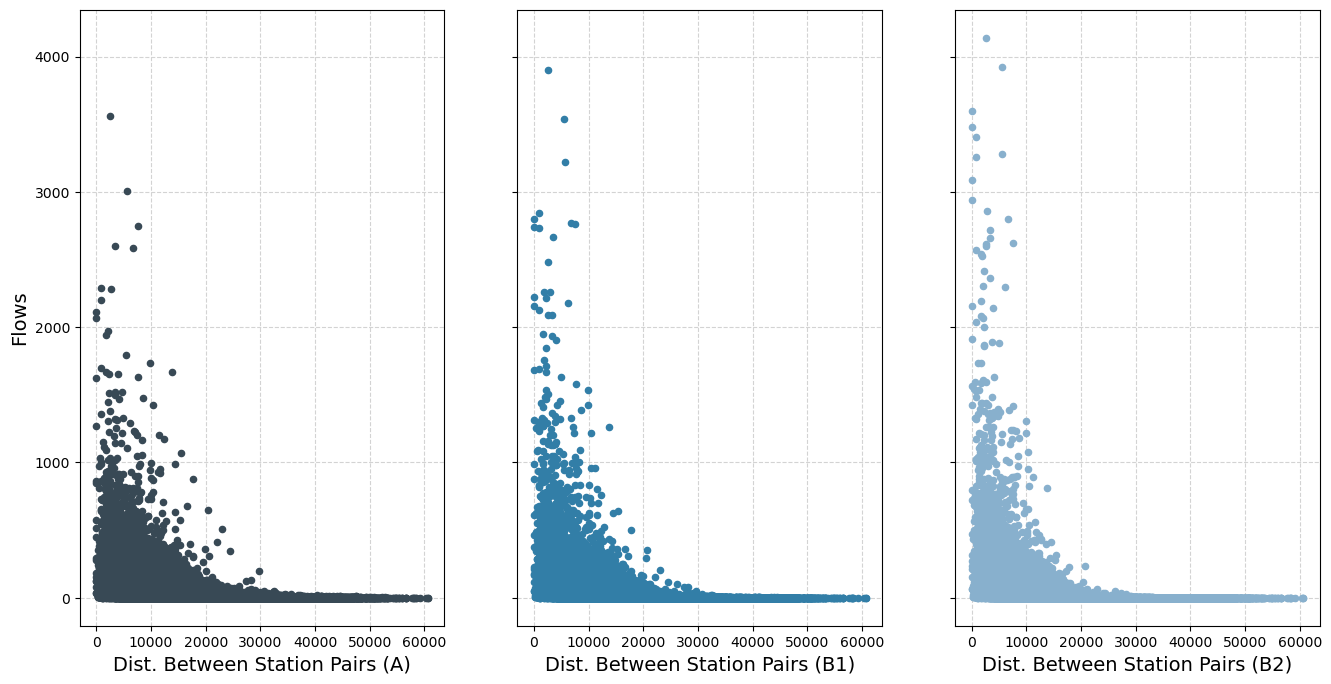

In [175]:
#Scatterplot/regression
#Basic vis
fig, axs = plt.subplots(1, 3, sharey=True, sharex=True)

plta = flows.plot(kind='scatter', x='distance', y='flows_scenario_a', ax=axs[0], figsize=(16, 8), color='#384955', zorder=2)
plta.set_xlabel('Dist. Between Station Pairs (A)', fontsize=14)
plta.set_ylabel('Flows' ,fontsize=14)
plta.grid(color='#d3d3d3', linestyle='--', zorder=1)

pltb1 = flows.plot(kind='scatter', x='distance', y='flows_scenario_b1', ax=axs[1], figsize=(16, 8), color='#327EA7', zorder=2)
pltb1.set_xlabel('Dist. Between Station Pairs (B1)', fontsize=14)
pltb1.set_ylabel('Flows' ,fontsize=14)
pltb1.grid(color='#d3d3d3', linestyle='--', zorder=1)

pltb2 = flows.plot(kind='scatter', x='distance', y='flows_scenario_b2', ax=axs[2], figsize=(16, 8), color='#88B0CD', zorder=2)
pltb2.set_xlabel('Dist. Between Station Pairs (B2)', fontsize=14)
pltb2.set_ylabel('Flows' ,fontsize=14)
pltb2.grid(color='#d3d3d3', linestyle='--', zorder=1)

/Users/gavinrolls/anaconda3/envs/urbsim/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


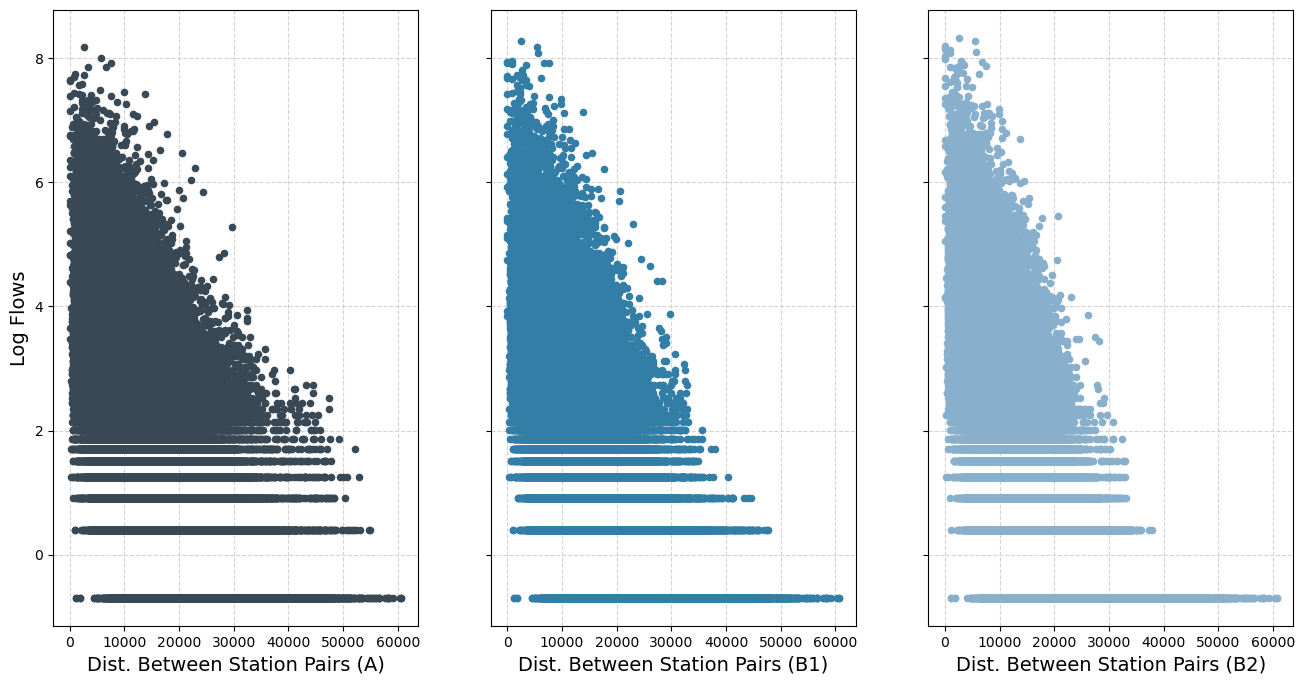

In [176]:
#Scatterplot/regression log versus distance

fig, axs = plt.subplots(1, 3, sharey=True, sharex=True)

flows['log_flows_scenario_a'] = np.log(flows['flows_scenario_a'] + .5)
flows['log_flows_scenario_b1'] = np.log(flows['flows_scenario_b1'] + .5)
flows['log_flows_scenario_b2'] = np.log(flows['flows_scenario_b2']+ .5)

flows['log_dist'] = np.log(flows['distance'])

plta = flows.plot(kind='scatter', x='distance', y='log_flows_scenario_a', ax=axs[0], figsize=(16, 8), color='#384955', zorder=2)
plta.set_xlabel('Dist. Between Station Pairs (A)', fontsize=14)
plta.set_ylabel('Log Flows' ,fontsize=14)
plta.grid(color='#d3d3d3', linestyle='--', zorder=1)

pltb1 = flows.plot(kind='scatter', x='distance', y='log_flows_scenario_b1', ax=axs[1], figsize=(16, 8), color='#327EA7', zorder=2)
pltb1.set_xlabel('Dist. Between Station Pairs (B1)', fontsize=14)
pltb1.set_ylabel('Log Flows' ,fontsize=14)
pltb1.grid(color='#d3d3d3', linestyle='--', zorder=1)

pltb2 = flows.plot(kind='scatter', x='distance', y='log_flows_scenario_b2', ax=axs[2], figsize=(16, 8), color='#88B0CD', zorder=2)
pltb2.set_xlabel('Dist. Between Station Pairs (B2)', fontsize=14)
pltb2.set_ylabel('Log Flows' ,fontsize=14)
pltb2.grid(color='#d3d3d3', linestyle='--', zorder=1)

In [181]:
#Linear Regression of each of the above figures
a_reg = smf.ols(formula='log_flows_scenario_a ~ distance', data = flows).fit()
b1_reg = smf.ols(formula='log_flows_scenario_b1 ~ distance', data = flows).fit()
b2_reg = smf.ols(formula='log_flows_scenario_b2 ~ distance', data = flows).fit()

print(a_reg.params[1])
print(b1_reg.params[1])
print(b2_reg.params[1])

print(a_reg.summary())
print(b1_reg.summary())
print(b2_reg.summary())


-0.00010643114144055629
-0.00012841322984135755
-0.00014101526717886085
                             OLS Regression Results                             
Dep. Variable:     log_flows_scenario_a   R-squared:                       0.371
Model:                              OLS   Adj. R-squared:                  0.371
Method:                   Least Squares   F-statistic:                 3.622e+04
Date:                  Sun, 25 Feb 2024   Prob (F-statistic):               0.00
Time:                          17:16:37   Log-Likelihood:            -1.0353e+05
No. Observations:                 61474   AIC:                         2.071e+05
Df Residuals:                     61472   BIC:                         2.071e+05
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_1342/105310512.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(a_reg.params[1])
/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_1342/105310512.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(b1_reg.params[1])
/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_1342/105310512.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(b2_re